導入庫 前置設定

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning and info message
import tensorflow as tf
import numpy as np
import random

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

下載text8

In [3]:
import os
import urllib

# Download the data.
DOWNLOAD_URL = 'http://mattmahoney.net/dc/'
DATA_FOLDER = "data"
FILE_NAME = "text8.zip"
EXPECTED_BYTES = 31344016

def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass
    
def download(file_name, expected_bytes):
    """ Download the dataset text8 if it's not already downloaded """
    local_file_path = os.path.join(DATA_FOLDER, file_name)
    if os.path.exists(local_file_path):
        print("Dataset ready")
        return local_file_path
    file_name, _ = urllib.request.urlretrieve(os.path.join(DOWNLOAD_URL, file_name), local_file_path)
    file_stat = os.stat(local_file_path)
    if file_stat.st_size == expected_bytes:
        print('Successfully downloaded the file', file_name)
    else:
        raise Exception(
              'File ' + file_name +
              ' might be corrupted. You should try downloading it with a browser.')
    return local_file_path    
    
make_dir(DATA_FOLDER)
file_path = download(FILE_NAME, EXPECTED_BYTES)

Dataset ready


In [25]:
import zipfile

# Read the data into a list of strings.
def read_data(file_path):
    """ Read data into a list of tokens """
    with zipfile.ZipFile(file_path) as f:
        # tf.compat.as_str() converts the input into string
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data(file_path)
print('Data size', len(vocabulary))

vocabulary[:5]

Data size 17005207


['anarchism', 'originated', 'as', 'a', 'term']

構建字典

In [26]:
import collections
# Build the dictionary and replace rare words with UNK token.
def build_dataset(words, n_words):
    """ Create two dictionaries and count of occuring words
        - word_to_id: map of words to their codes
        - id_to_word: maps codes to words (inverse word_to_id)
        - count: map of words to count of occurrences
    """
    # map unknown words to -1
    count = [['UNK', -1]]
    # count of occurences for words in vocabulary
    count.extend(collections.Counter(words).most_common(n_words - 1)) 
    word_to_id = dict() # (word, id)
    # record word id
    for word, _ in count:
        word_to_id[word] = len(word_to_id)
    id_to_word = dict(zip(word_to_id.values(), word_to_id.keys())) # (id, word)
    return word_to_id, id_to_word, count

def convert_words_to_id(words, dictionary, count):
    """ Replace each word in the dataset with its index in the dictionary """
    data_w2id = []
    unk_count = 0
    for word in words:
        # return 0 if word is not in dictionary
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data_w2id.append(index)
    count[0][1] = unk_count
    return data_w2id, count

"""Filling 4 global variables:
# data_w2id - list of codes (integers from 0 to vocabulary_size-1).
              This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# word_to_id - map of words(strings) to their codes(integers)
# id_to_word - maps codes(integers) to words(strings)
"""

vocabulary_size = 50000
word_to_id, id_to_word, count = build_dataset(vocabulary, vocabulary_size)
data_w2id, count = convert_words_to_id(vocabulary, word_to_id, count)
del vocabulary  # reduce memory.

print('Most common words (+UNK)', count[:5])
print('Sample data: {}'.format(data_w2id[:10]))
print([id_to_word[i] for i in data_w2id[:10]])

# utility function
def generate_sample(center_words, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for idx, center in enumerate(center_words):
        context = random.randint(1, context_window_size)
        # get a random target before the center word
        for target in center_words[max(0, idx - context) : idx]:
            yield center, target
        # get a random target after the center word
        for target in center_words[idx + 1 : idx + context + 1]:
            yield center, target

def batch_generator(data, skip_window, batch_size):
    """ Group a numeric stream into batches and yield them as Numpy arrays. """
    single_gen = generate_sample(data, skip_window)
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for idx in range(batch_size):
            center_batch[idx], target_batch[idx] = next(single_gen)
        yield center_batch, target_batch

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data: [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


子類化構建Model

示例代碼

In [59]:
## some training settings
training_steps = 80000
skip_step = 2000

## some hyperparameters
batch_size = 512
embed_size = 512
num_sampled = 256
learning_rate = 1.0

# from tensorflow.keras.layers import Layer
from tensorflow.python.keras.layers import Layer

# embedding matrix - hidden layer
class embedding_lookup(Layer):
    def __init__(self):
        super(embedding_lookup, self).__init__()
        embedding_init = tf.keras.initializers.GlorotUniform()
        self.embedding_matrix = self.add_weight(name="embedding_matrix",
                                                trainable=True,
                                                shape=[vocabulary_size, embed_size],
                                                initializer=embedding_init)

    def call(self, inputs):
        center_words = inputs
        embedding = tf.nn.embedding_lookup(self.embedding_matrix,
                                           center_words, 
                                           name='embedding')
        return embedding

# context matrix - prediction layer
class nce_loss(Layer):
    def __init__(self):
        super(nce_loss, self).__init__()
        nce_w_init = tf.keras.initializers.TruncatedNormal(stddev=1.0/(embed_size ** 0.5))
        self.nce_weight = self.add_weight(name='nce_weight',
                                          trainable=True,
                                          shape=[vocabulary_size, embed_size],
                                          initializer=nce_w_init)
        self.nce_bias = self.add_weight(name='nce_bias',
                                        trainable=True,
                                        shape=[vocabulary_size],
                                        initializer=tf.keras.initializers.Zeros)

    def call(self, inputs):
        embedding, target_words = inputs[0], inputs[1]
        loss = tf.reduce_mean(tf.nn.nce_loss(weights=self.nce_weight, 
                                             biases=self.nce_bias, 
                                             labels=target_words, 
                                             inputs=embedding, 
                                             num_sampled=num_sampled, 
                                             num_classes=vocabulary_size),
                                             name='loss')
        return loss

In [ ]:
from tensorflow.keras import Model


class Word2Vec(Model):
    def __init__(self):
        super(Word2Vec, self).__init__()
        # 组合示例里的两个层（作为子模块）
        self.embed_layer = embedding_lookup()
        self.nce_layer   = nce_loss()

    def call(self, center_words, target_words):
        """
        center_words: int32/int64 [B]
        target_words: int32/int64 [B, 1]
        返回：标量 loss（tf.float32）
        """
        # 用示例的 embedding 層做查表
        embedding = self.embed_layer(center_words)          # [B, D]
        # 用示例的 nce_loss 層計算loss
        loss = self.nce_layer((embedding, target_words))    # 标量
        return loss

    @property
    def embedding_matrix(self):
        return self.embed_layer.embedding_matrix

    @property
    def nce_weight(self):
        return self.nce_layer.nce_weight

    @property
    def nce_bias(self):
        return self.nce_layer.nce_bias


In [ ]:
import tensorflow as tf

def gen():
    yield from batch_generator(data_w2id, skip_window, batch_size)

dataset = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(batch_size,),   dtype=tf.int32),
        tf.TensorSpec(shape=(batch_size, 1), dtype=tf.int32),
    )
).repeat()


In [62]:
w2v = Word2Vec()  
optimizer  = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.1, nesterov=True)
train_loss = tf.keras.metrics.Mean(name='train_loss')

@tf.function
def train_step(centers, targets):
    with tf.GradientTape() as tape:
        loss = w2v(centers, targets)
    grads = tape.gradient(loss, w2v.trainable_variables)
    optimizer.apply_gradients(zip(grads, w2v.trainable_variables))
    train_loss.update_state(loss)

x_steps, y_loss = [], []
for step, (centers, targets) in enumerate(dataset):
    if step == training_steps:
        break
    train_step(centers, targets)
    if (step + 1) % skip_step == 0:
        curr = float(train_loss.result().numpy())
        x_steps.append(step + 1)
        y_loss.append(curr)
        print(f"Step {step+1}, Loss: {curr:.4f}")
        train_loss.reset_states()


Step 2000, Loss: 174.5168
Step 4000, Loss: 31.6592
Step 6000, Loss: 15.4501
Step 8000, Loss: 10.7827
Step 10000, Loss: 9.6284
Step 12000, Loss: 8.7191
Step 14000, Loss: 8.1545
Step 16000, Loss: 7.4676
Step 18000, Loss: 7.1664
Step 20000, Loss: 6.9597
Step 22000, Loss: 6.9022
Step 24000, Loss: 6.7013


KeyboardInterrupt: 

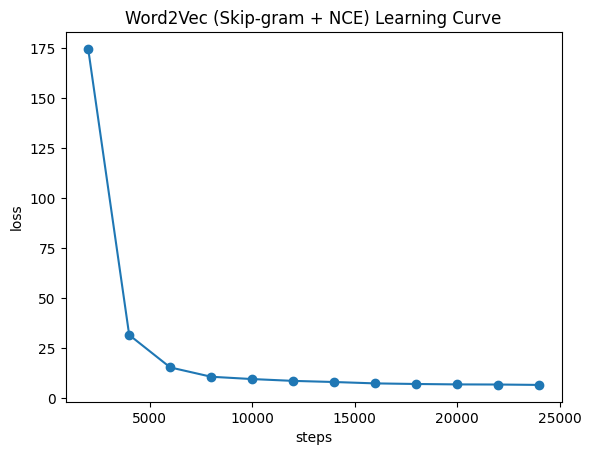

In [63]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(x_steps, y_loss, marker='o')
plt.xlabel("steps"); plt.ylabel("loss")
plt.title("Word2Vec (Skip-gram + NCE) Learning Curve")
plt.show()

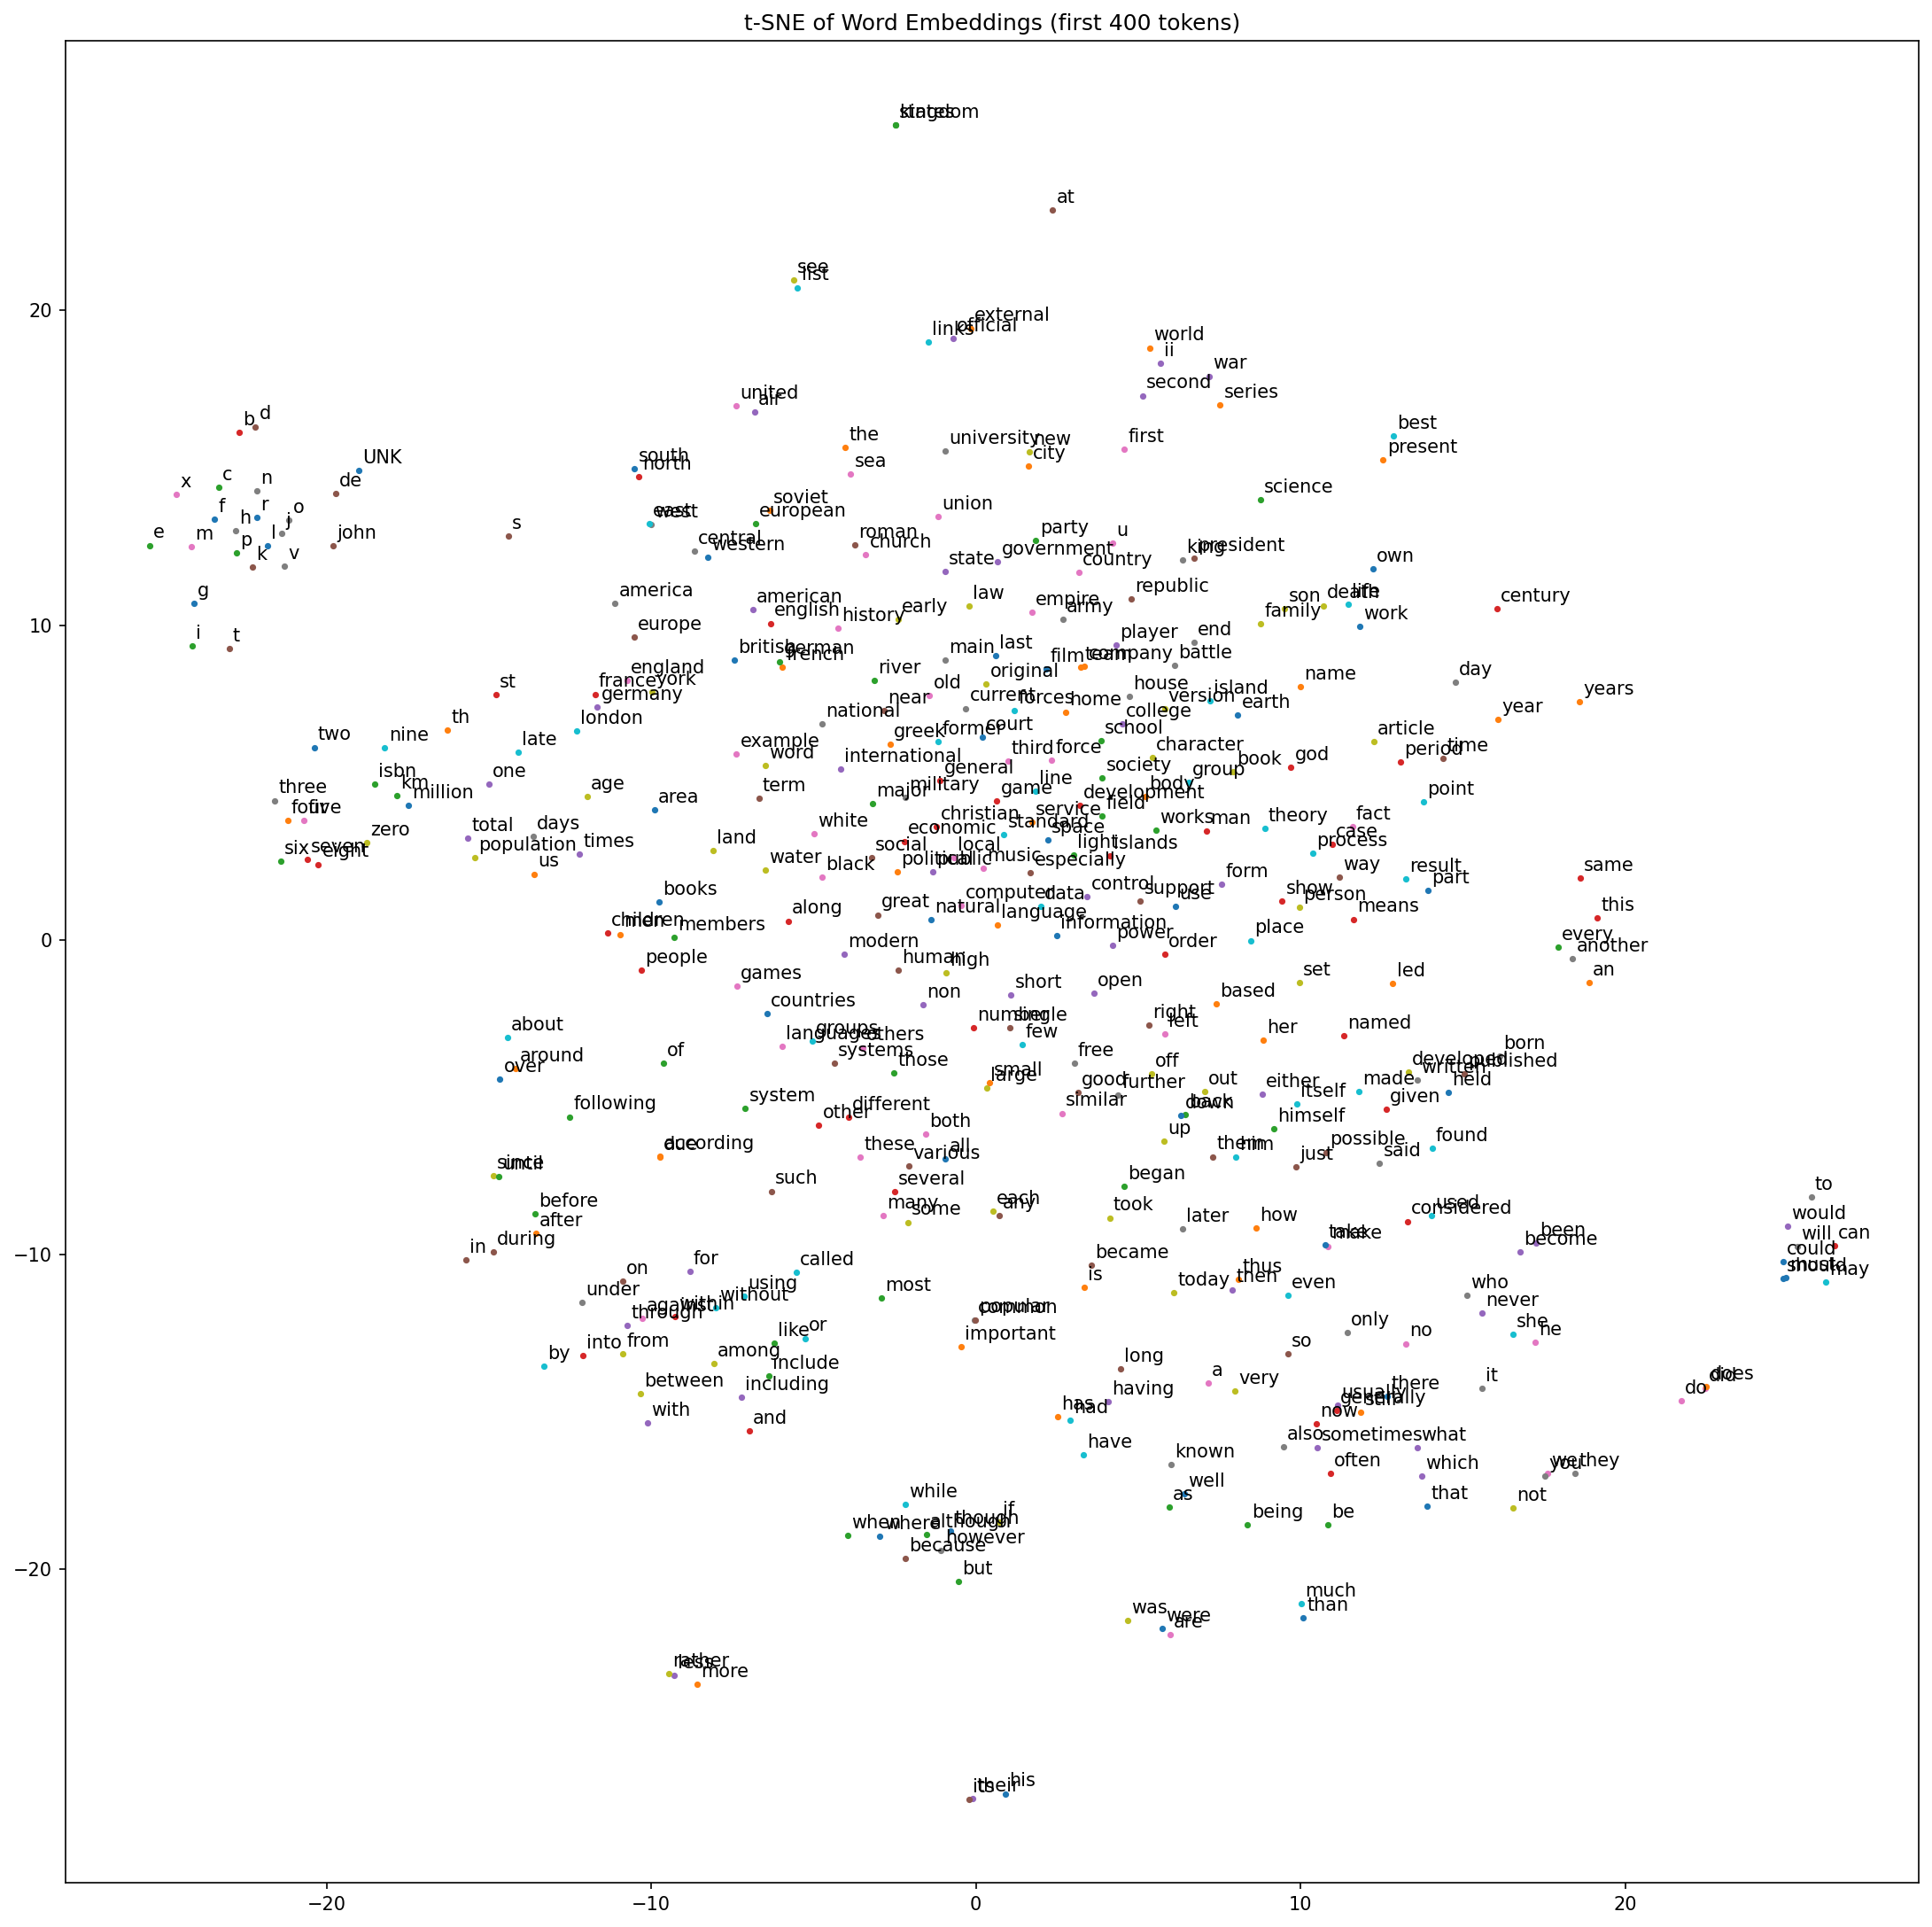

In [64]:
from sklearn.manifold import TSNE

embedding_matrix = w2v.embedding_matrix.numpy()

plot_only = 400  
tsne = TSNE(
    perplexity=30,
    n_components=2,
    init='pca',
    n_iter=5000,
    method='exact',
    learning_rate='auto',
    random_state=628
)
low_dim_embs = tsne.fit_transform(embedding_matrix[:plot_only, :])
labels = [id_to_word[i] for i in range(plot_only)]

def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels)
    plt.figure(figsize=(18, 18), dpi=150)
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i]
        plt.scatter(x, y, s=6)
        plt.annotate(label, xy=(x, y), xytext=(2, 2),
                     textcoords='offset points', ha='left', va='bottom')
    plt.title("t-SNE of Word Embeddings (first 400 tokens)")
    plt.show()

plot_with_labels(low_dim_embs, labels)


In [65]:
import numpy.linalg as LA

def cos_sim(word1, word2):
    i1 = word_to_id.get(word1)
    i2 = word_to_id.get(word2)
    if i1 is None or i2 is None:
        raise ValueError("word not in vocabulary")
    v1 = embedding_matrix[i1]
    v2 = embedding_matrix[i2]
    return float(np.dot(v1, v2) / (LA.norm(v1) * LA.norm(v2) + 1e-12))

def top_k_nearest(word, k=5):
    idx = word_to_id.get(word)
    if idx is None:
        raise ValueError("word not in vocabulary")
    vec = embedding_matrix[idx]
    dots = embedding_matrix @ vec
    norms = LA.norm(embedding_matrix, axis=1) * (LA.norm(vec) + 1e-12)
    sims = dots / (norms + 1e-12)
    order = np.argsort(-sims)[:k]
    print(f"--- top {k} nearest of '{word}' ---")
    for j in order:
        print(id_to_word[j])
    print()

print("cos_sim('cat','dog') =", cos_sim('cat','dog'))

top_k_nearest('music', 5)
top_k_nearest('country', 5)


cos_sim('cat','dog') = 0.9919324497962967
--- top 5 nearest of 'music' ---
music
business
design
traditional
local

--- top 5 nearest of 'country' ---
country
region
team
company
building

